In [28]:
equilibrium <- read.csv('~/ResearchProjects/JAPE/ConcurrentData/matching_by_session.csv')
stable <- subset(equilibrium,!dynamic_env)

In [29]:
bb <- unique(stable$bird)[2]
bb_stable <- subset(stable,bird==bb)
head(bb_stable,3)

,session,bird,n_resp_left,n_resp_right,n_reinf_left,n_reinf_right,dynamic_env
,<chr>,<chr>,<int>,<int>,<int>,<int>,<lgl>
181,s01,p054,236,277,33,17,FALSE
182,s02,p054,511,329,51,19,FALSE
183,s03,p054,271,247,26,14,FALSE


In [30]:
library('R2jags')

In [42]:
B_r <- bb_stable$n_resp_right
B_l <- bb_stable$n_resp_left
W_r <- bb_stable$n_reinf_right
W_l <- bb_stable$n_reinf_left
n_obs <- length(B_r)

log_Beh <- log(B_r/B_l)
log_Rew <- log(W_r/W_l)

observed <- list('B_r','B_l','W_r','W_l','n_obs',
                'log_Beh','log_Rew')
unobserved <- c('alpha_prior','alpha_post',
               'beta_prior','beta_post',
               'lambda_r_prior','lambda_r_post',
               'lambda_l_prior','lambda_l_post',
               'sigma_prior','sigma_post',
               'log_B_post','log_B_prior',
               'log_B','log_W')

write('model{
    alpha_prior~dnorm(0,1)
    beta_prior~dnorm(0,1)
    tau_prior~dgamma(0.01,0.01)T(0.01,)
    alpha_post~dnorm(0,1)
    beta_post~dnorm(0,1)
    tau_post~dgamma(0.01,0.01)T(0.01,)
    sigma_post <- 1/tau_post^(1/2)
    sigma_prior <- 1/tau_prior^(1/2)

    for(j in 1:100){
        log_W[j] <- (j-50)/15
        log_B[j] <- alpha_post+beta_post*log_W[j]
    }


    for(i in 1:n_obs){
        lambda_r_prior[i]~dlnorm(alpha_prior/2+beta_prior*log(W_r[i]),tau_prior)
        lambda_l_prior[i]~dlnorm(-alpha_prior/2-beta_prior*log(W_l[i]),tau_prior)

#         lambda_r_post[i]~dlnorm(alpha_post/2+beta_post*log(W_r[i]),tau_post)
#         lambda_l_post[i]~dlnorm(-alpha_post/2-beta_post*log(W_l[i]),tau_post)

        lambda_r_post[i]~dlnorm(alpha_post/2+beta_post*log(W_r[i]/W_l[i]),tau_post)
        lambda_l_post[i]~dlnorm(-alpha_post/2-beta_post*log(W_l[i]/W_l[i]),tau_post)

        B_r[i]~dpois(lambda_r_post[i])
        B_l[i]~dpois(lambda_l_post[i])

        # POSTERIOR prediction
        B_r_post[i]~dpois(lambda_r_post[i])
        B_l_post[i]~dpois(lambda_l_post[i])
        log_B_post[i] <- log(B_r_post[i]/B_l_post[i])
        
        
        # PRIOR prediction
#         B_r_prior[i]~dpois(lambda_r_prior[i])T(1,)
#         B_l_prior[i]~dpois(lambda_l_prior[i])T(1,)
#         log_B_prior[i] <- log(B_r_prior[i]/B_l_prior[i])
    }
}','generative_matching.bug')


set.seed(1)

bayes_gen <- jags(data = observed,
             parameters.to.save = unobserved,
             model.file = 'generative_matching.bug')
unlink('generative_matching.bug')

write('model{
    alpha_prior~dnorm(0,1)
    beta_prior~dnorm(0,1)
    tau_prior~dgamma(0.01,0.01)T(0.01,)
    alpha_post~dnorm(0,1)
    beta_post~dnorm(0,1)
    tau_post~dgamma(0.01,0.01)T(0.01,)
    sigma_post <- 1/tau_post^(1/2)
    sigma_prior <- 1/tau_prior^(1/2)

    for(i in 1:n_obs){
        log_Beh[i]~dnorm(alpha_post+beta_post*log_Rew[i],tau_post)
        log_B_post[i]~dnorm(alpha_post+beta_post*log_Rew[i],tau_post)
        log_B_prior[i]~dnorm(alpha_prior+beta_prior*log_Rew[i],tau_prior)
    }
}','non_generative_matching.bug')

bayes_non_gen <- jags(data = observed,
             parameters.to.save = unobserved,
             model.file = 'non_generative_matching.bug')
unlink('non_generative_matching.bug')

Warning message in jags.model(model.file, data = data, inits = init.values, n.chains = n.chains, :
“Unused variable "log_Beh" in data”
Warning message in jags.model(model.file, data = data, inits = init.values, n.chains = n.chains, :
“Unused variable "log_Rew" in data”


Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 290
   Unobserved stochastic nodes: 876
   Total graph size: 3076

Initializing model



Warning message in FUN(X[[i]], ...):
“Failed to set trace monitor for log_B_prior
Variable log_B_prior not found
”
Warning message in jags.model(model.file, data = data, inits = init.values, n.chains = n.chains, :
“Unused variable "B_r" in data”
Warning message in jags.model(model.file, data = data, inits = init.values, n.chains = n.chains, :
“Unused variable "B_l" in data”
Warning message in jags.model(model.file, data = data, inits = init.values, n.chains = n.chains, :
“Unused variable "W_r" in data”
Warning message in jags.model(model.file, data = data, inits = init.values, n.chains = n.chains, :
“Unused variable "W_l" in data”


Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 145
   Unobserved stochastic nodes: 296
   Total graph size: 1108

Initializing model



Warning message in FUN(X[[i]], ...):
“Failed to set trace monitor for lambda_r_prior
Variable lambda_r_prior not found
”
Warning message in FUN(X[[i]], ...):
“Failed to set trace monitor for lambda_r_post
Variable lambda_r_post not found
”
Warning message in FUN(X[[i]], ...):
“Failed to set trace monitor for lambda_l_prior
Variable lambda_l_prior not found
”
Warning message in FUN(X[[i]], ...):
“Failed to set trace monitor for lambda_l_post
Variable lambda_l_post not found
”
Warning message in FUN(X[[i]], ...):
“Failed to set trace monitor for log_B
Variable log_B not found
”
Warning message in FUN(X[[i]], ...):
“Failed to set trace monitor for log_W
Variable log_W not found
”


In [43]:
summary(bayes_gen$BUGSoutput$summary[,c('Rhat','n.eff')])
summary(bayes_non_gen$BUGSoutput$summary[,c('Rhat','n.eff')])

      Rhat           n.eff     
 Min.   :1.000   Min.   :   1  
 1st Qu.:1.001   1st Qu.:1400  
 Median :1.001   Median :2950  
 Mean   :1.001   Mean   :2169  
 3rd Qu.:1.002   3rd Qu.:3000  
 Max.   :1.009   Max.   :3000  

      Rhat           n.eff     
 Min.   :1.001   Min.   : 520  
 1st Qu.:1.001   1st Qu.:2100  
 Median :1.001   Median :3000  
 Mean   :1.002   Mean   :2514  
 3rd Qu.:1.002   3rd Qu.:3000  
 Max.   :1.027   Max.   :3000  

In [44]:
nds_gen <- bayes_gen$BUGSoutput$sims.list
nds_non_gen <- bayes_non_gen$BUGSoutput$sims.list

In [45]:
names(nds_non_gen)

[1] "alpha_post"  "alpha_prior" "beta_post"   "beta_prior"  "deviance"   
[6] "log_B_post"  "log_B_prior" "sigma_post"  "sigma_prior"

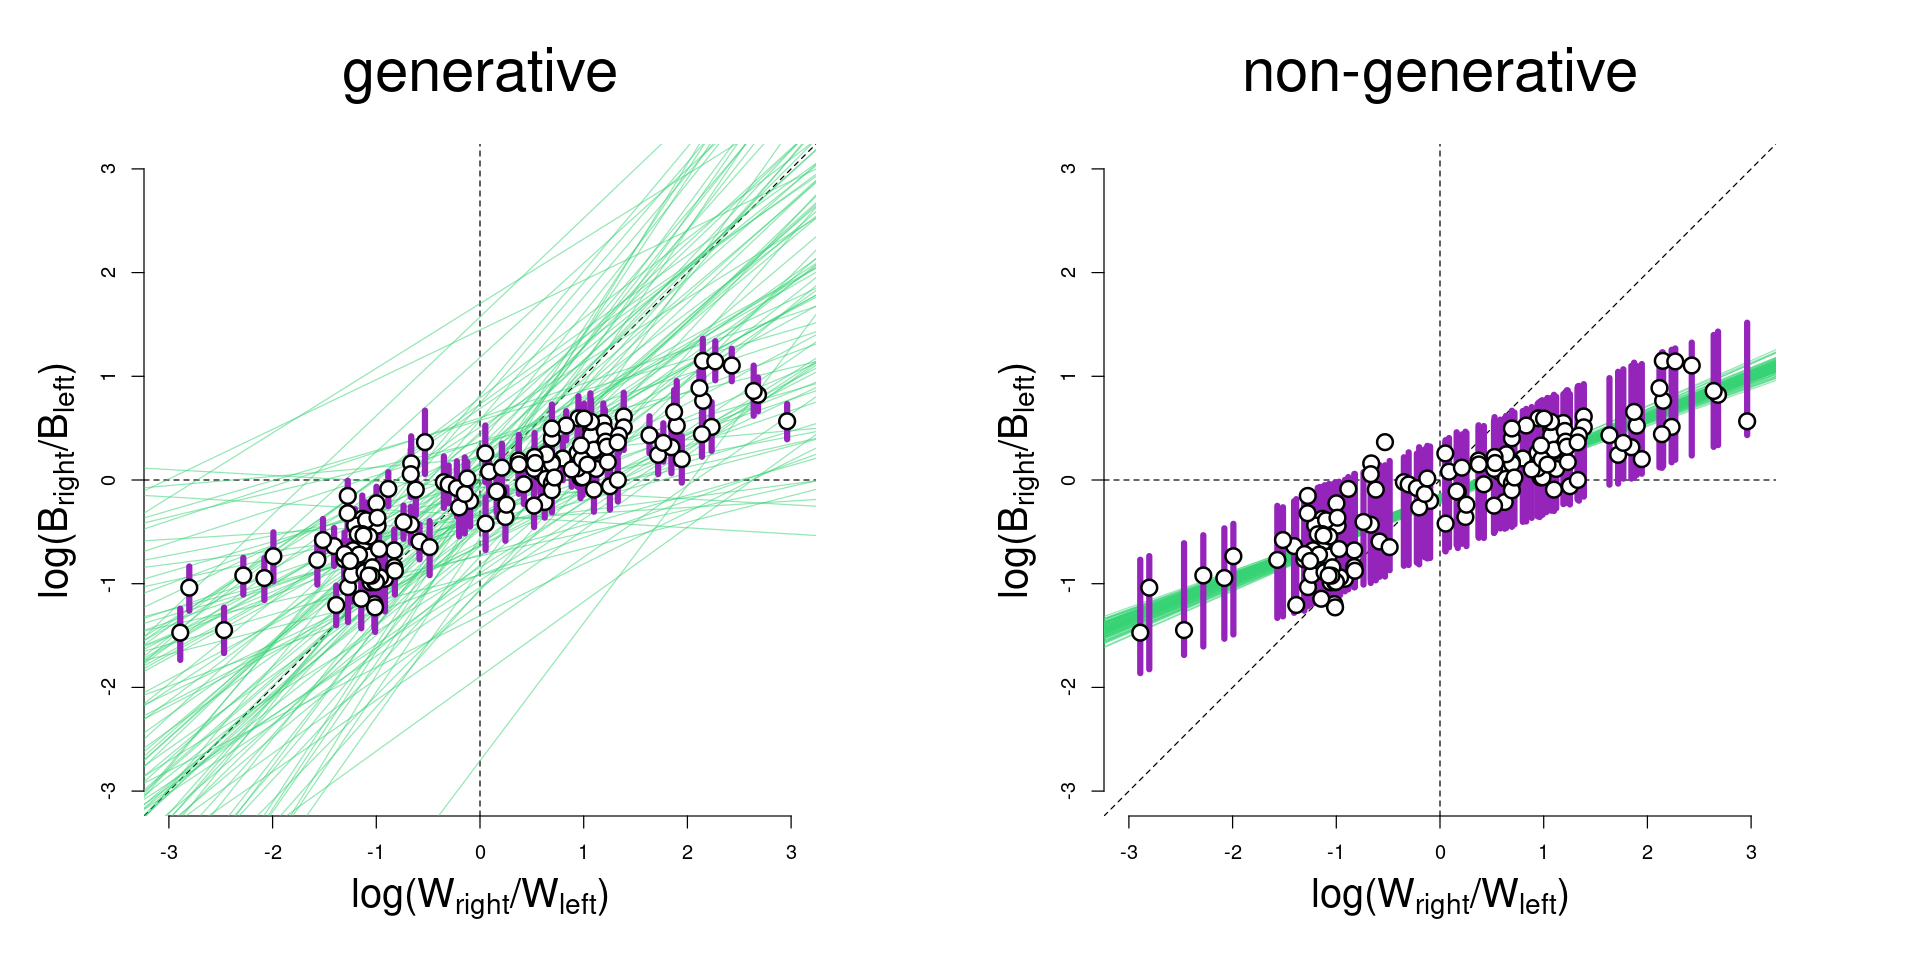

In [48]:
post_predictive <- function(nds,
                            prediction='posterior',
                            title=NULL){
    # nds <- nds_gen
#     if(prediction=='posterior'){
        pred_node <- nds$log_B_post
    
#         pred_node <- nds$log_B_prior
#     }
    plot(NULL,xlim=c(-3,3),ylim=c(-3,3),axes=F,ann=F)
    axis(1);axis(2)
    mtext(title,3,cex=3,line=2)
    mtext(expression(paste(log,'(',W[right],'/',W[left],')')),1,cex=2,line=3.5)
    mtext(expression(paste(log,'(',B[right],'/',B[left],')')),2,cex=2,line=2.5)
    abline(0,1,lty='dashed')
    abline(v=0,lty='dashed')
    abline(h=0,lty='dashed')

    
    smpl <- sample(x = dim(nds$log_B_post)[1],size = 100)
    for(j in smpl){
        abline(nds$alpha_post[j],
               nds$beta_post[j],col='#37d27588')

    }
    
    
    for(i in 1:nrow(bb_stable)){
#         pred <- quantile(nds$log_B_post[,i],probs = c(0.025,0.975))
        pred <- quantile(pred_node[,i],probs = c(0.025,0.975))
        lines(rep(log(W_r[i]/W_l[i]),2),pred,lwd=5,col='#9525ba')
    }


    points(log(bb_stable$n_reinf_right/bb_stable$n_reinf_left),
           log(bb_stable$n_resp_right/bb_stable$n_resp_left),
           pch=21,lwd=2,cex=1.75,bg='#ffffff')

}

options(repr.plot.width=16,repr.plot.height=8)
par(mar=rep(6,4))
layout(matrix(1:2,ncol=2))
post_predictive(nds_gen,title='generative')
post_predictive(nds_non_gen,title='non-generative')

In [9]:
nds <- nds_gen
names(nds)

[1] "alpha_post"     "alpha_prior"    "beta_post"      "beta_prior"    
 [5] "deviance"       "lambda_l_post"  "lambda_l_prior" "lambda_r_post" 
 [9] "lambda_r_prior" "log_B"          "log_B_post"     "log_W"         
[13] "sigma_post"     "sigma_prior"

In [10]:
head(nds$log_B)

-6.375756,-6.253423,-6.131090,-6.008757,-5.886423,-5.764090,-5.641757,-5.519424,-5.397091,-5.274758,⋯,4.634230,4.756563,4.878896,5.001229,5.123562,5.245896,5.368229,5.490562,5.612895,5.735228
-6.362677,-6.240364,-6.118052,-5.995739,-5.873427,-5.751114,-5.628802,-5.506489,-5.384177,-5.261864,⋯,4.645447,4.767760,4.890072,5.012385,5.134697,5.257010,5.379322,5.501635,5.623947,5.746260
-6.382391,-6.257517,-6.132644,-6.007771,-5.882897,-5.758024,-5.633150,-5.508277,-5.383404,-5.258530,⋯,4.856216,4.981090,5.105963,5.230837,5.355710,5.480584,5.605457,5.730330,5.855204,5.980077
-6.448856,-6.325723,-6.202590,-6.079457,-5.956323,-5.833190,-5.710057,-5.586924,-5.463791,-5.340658,⋯,4.633130,4.756263,4.879396,5.002530,5.125663,5.248796,5.371929,5.495062,5.618196,5.741329
-6.386503,-6.260733,-6.134964,-6.009194,-5.883425,-5.757656,-5.631886,-5.506117,-5.380347,-5.254578,⋯,4.932746,5.058516,5.184285,5.310055,5.435824,5.561593,5.687363,5.813132,5.938902,6.064671
-6.549671,-6.426780,-6.303888,-6.180997,-6.058106,-5.935214,-5.812323,-5.689432,-5.566540,-5.443649,⋯,4.510548,4.633439,4.756331,4.879222,5.002113,5.125005,5.247896,5.370787,5.493679,5.616570


In [11]:
head(nds$log_W)

-3.266667,-3.2,-3.133333,-3.066667,-3,-2.933333,-2.866667,-2.8,-2.733333,-2.666667,⋯,2.733333,2.8,2.866667,2.933333,3,3.066667,3.133333,3.2,3.266667,3.333333
-3.266667,-3.2,-3.133333,-3.066667,-3,-2.933333,-2.866667,-2.8,-2.733333,-2.666667,⋯,2.733333,2.8,2.866667,2.933333,3,3.066667,3.133333,3.2,3.266667,3.333333
-3.266667,-3.2,-3.133333,-3.066667,-3,-2.933333,-2.866667,-2.8,-2.733333,-2.666667,⋯,2.733333,2.8,2.866667,2.933333,3,3.066667,3.133333,3.2,3.266667,3.333333
-3.266667,-3.2,-3.133333,-3.066667,-3,-2.933333,-2.866667,-2.8,-2.733333,-2.666667,⋯,2.733333,2.8,2.866667,2.933333,3,3.066667,3.133333,3.2,3.266667,3.333333
-3.266667,-3.2,-3.133333,-3.066667,-3,-2.933333,-2.866667,-2.8,-2.733333,-2.666667,⋯,2.733333,2.8,2.866667,2.933333,3,3.066667,3.133333,3.2,3.266667,3.333333
-3.266667,-3.2,-3.133333,-3.066667,-3,-2.933333,-2.866667,-2.8,-2.733333,-2.666667,⋯,2.733333,2.8,2.866667,2.933333,3,3.066667,3.133333,3.2,3.266667,3.333333


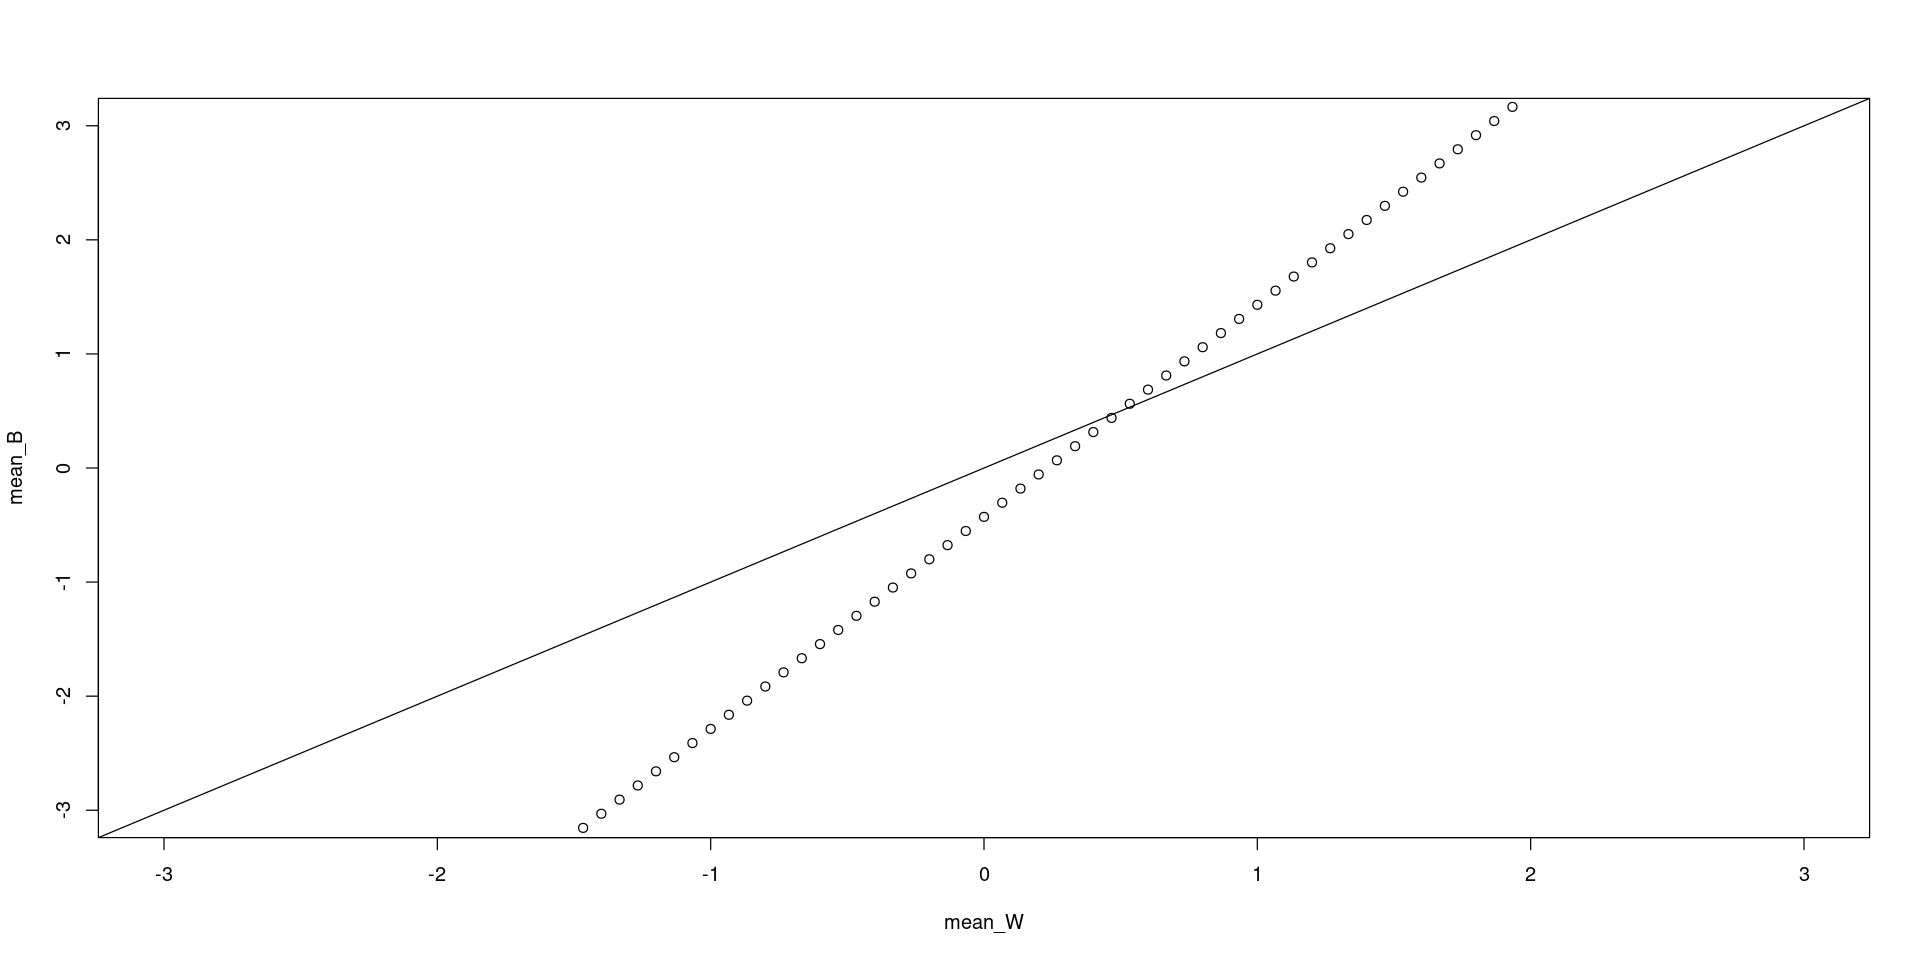

In [12]:
mean_B <- apply(nds$log_B,FUN=mean,MARGIN=2)
mean_W <- apply(nds$log_W,FUN=mean,MARGIN=2)
plot(mean_W,mean_B,xlim=c(-3,3),ylim=c(-3,3));abline(0,1)

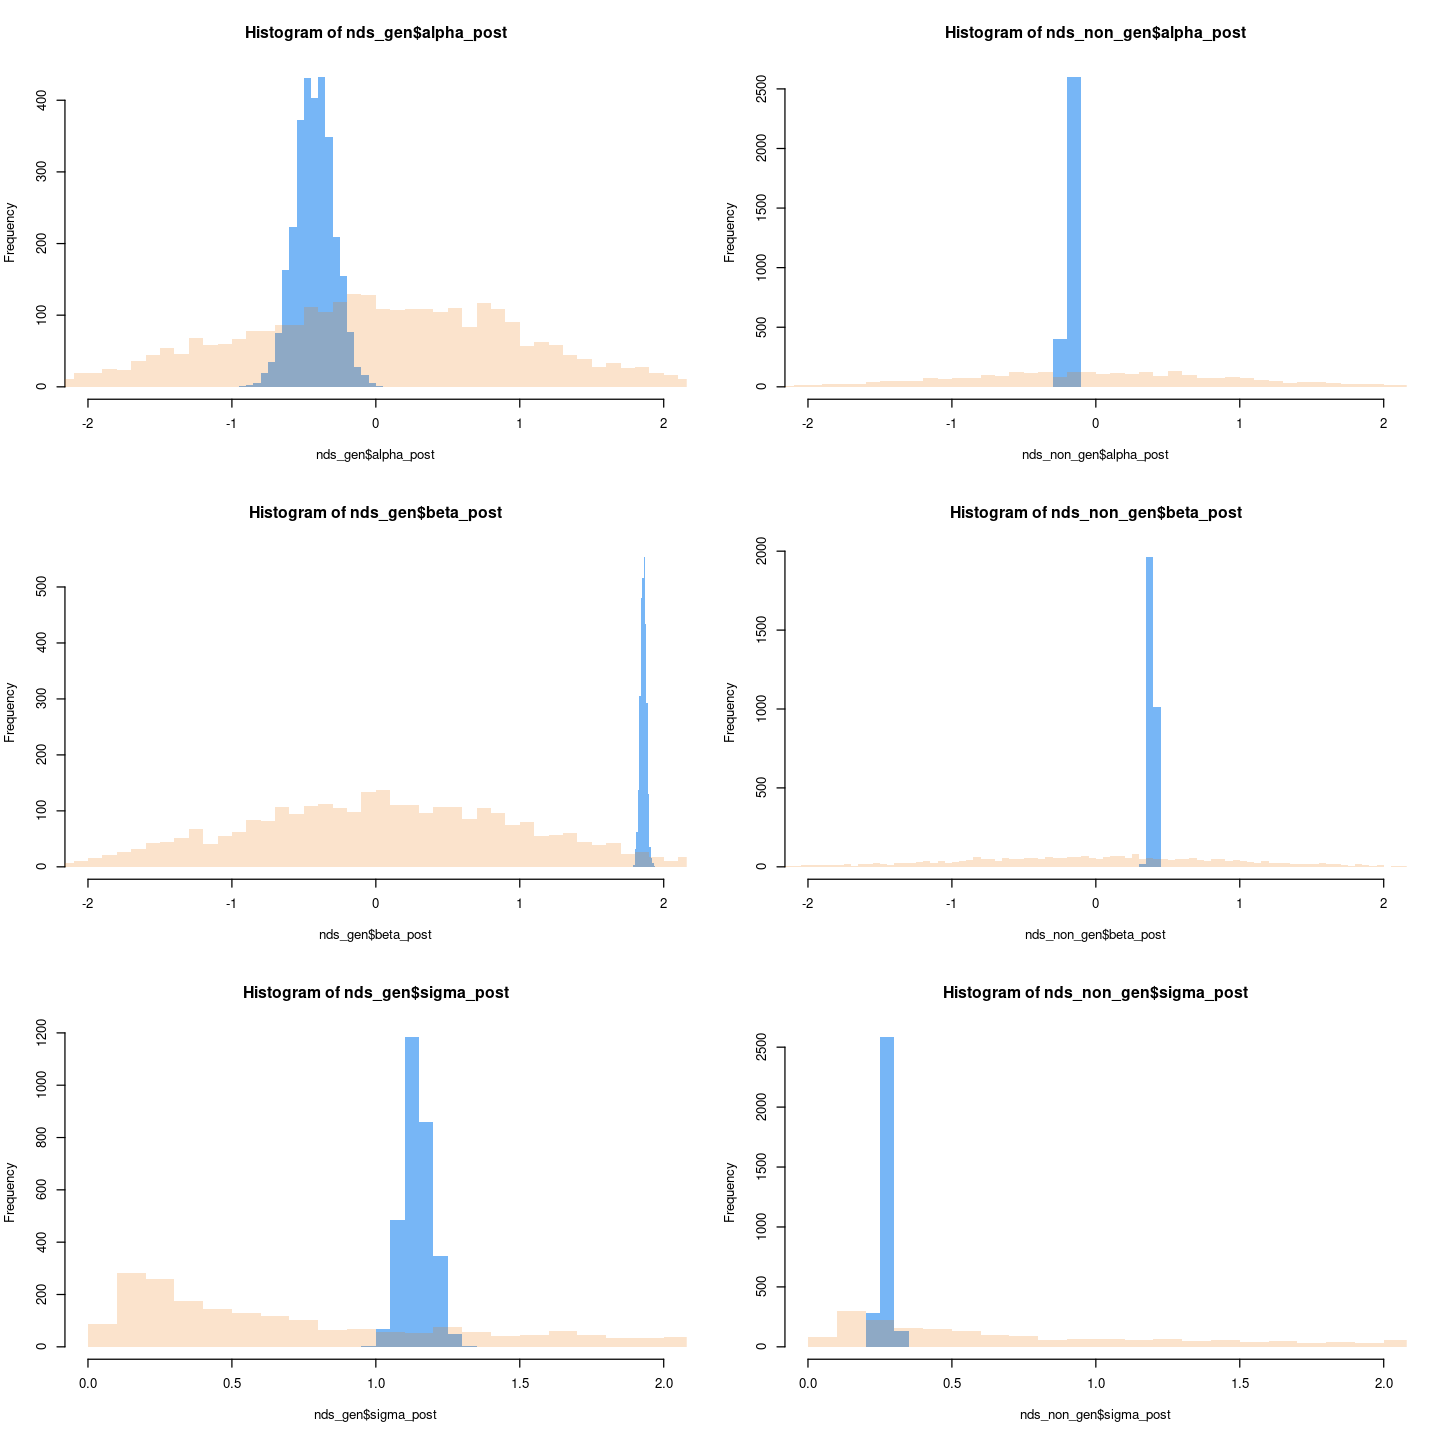

In [13]:
col_prior <- '#ee770033'
col_post <- '#0077ee88'

options(repr.plot.width=12,repr.plot.height=12)
layout(matrix(1:6,ncol=2,byrow=T))
hist(nds_gen$alpha_post,xlim=c(-2,2),border=NA,col=col_post)
hist(nds_gen$alpha_prior,xlim=c(-2,2),border=NA,col=col_prior,add=T,breaks=100)

hist(nds_non_gen$alpha_post,xlim=c(-2,2),border=NA,col=col_post)
hist(nds_non_gen$alpha_prior,xlim=c(-2,2),border=NA,col=col_prior,add=T,breaks=100)

hist(nds_gen$beta_post,xlim=c(-2,2),border=NA,col=col_post)
hist(nds_gen$beta_prior,xlim=c(-2,2),border=NA,col=col_prior,add=T,breaks=100)

hist(nds_non_gen$beta_post,xlim=c(-2,2),border=NA,col=col_post)
hist(nds_non_gen$beta_prior,xlim=c(-2,2),border=NA,col=col_prior,add=T,breaks=100)

hist(nds_gen$sigma_post,xlim=c(0,2),border=NA,col=col_post)
hist(nds_gen$sigma_prior,xlim=c(0,2),border=NA,col=col_prior,add=T,breaks=100)

hist(nds_non_gen$sigma_post,xlim=c(0,2),border=NA,col=col_post)
hist(nds_non_gen$sigma_prior,xlim=c(0,2),border=NA,col=col_prior,add=T,breaks=100)

In [19]:
names(nds_gen)

[1] "alpha_post"     "alpha_prior"    "beta_post"      "beta_prior"    
 [5] "deviance"       "lambda_l_post"  "lambda_l_prior" "lambda_r_post" 
 [9] "lambda_r_prior" "log_B"          "log_B_post"     "log_W"         
[13] "sigma_post"     "sigma_prior"

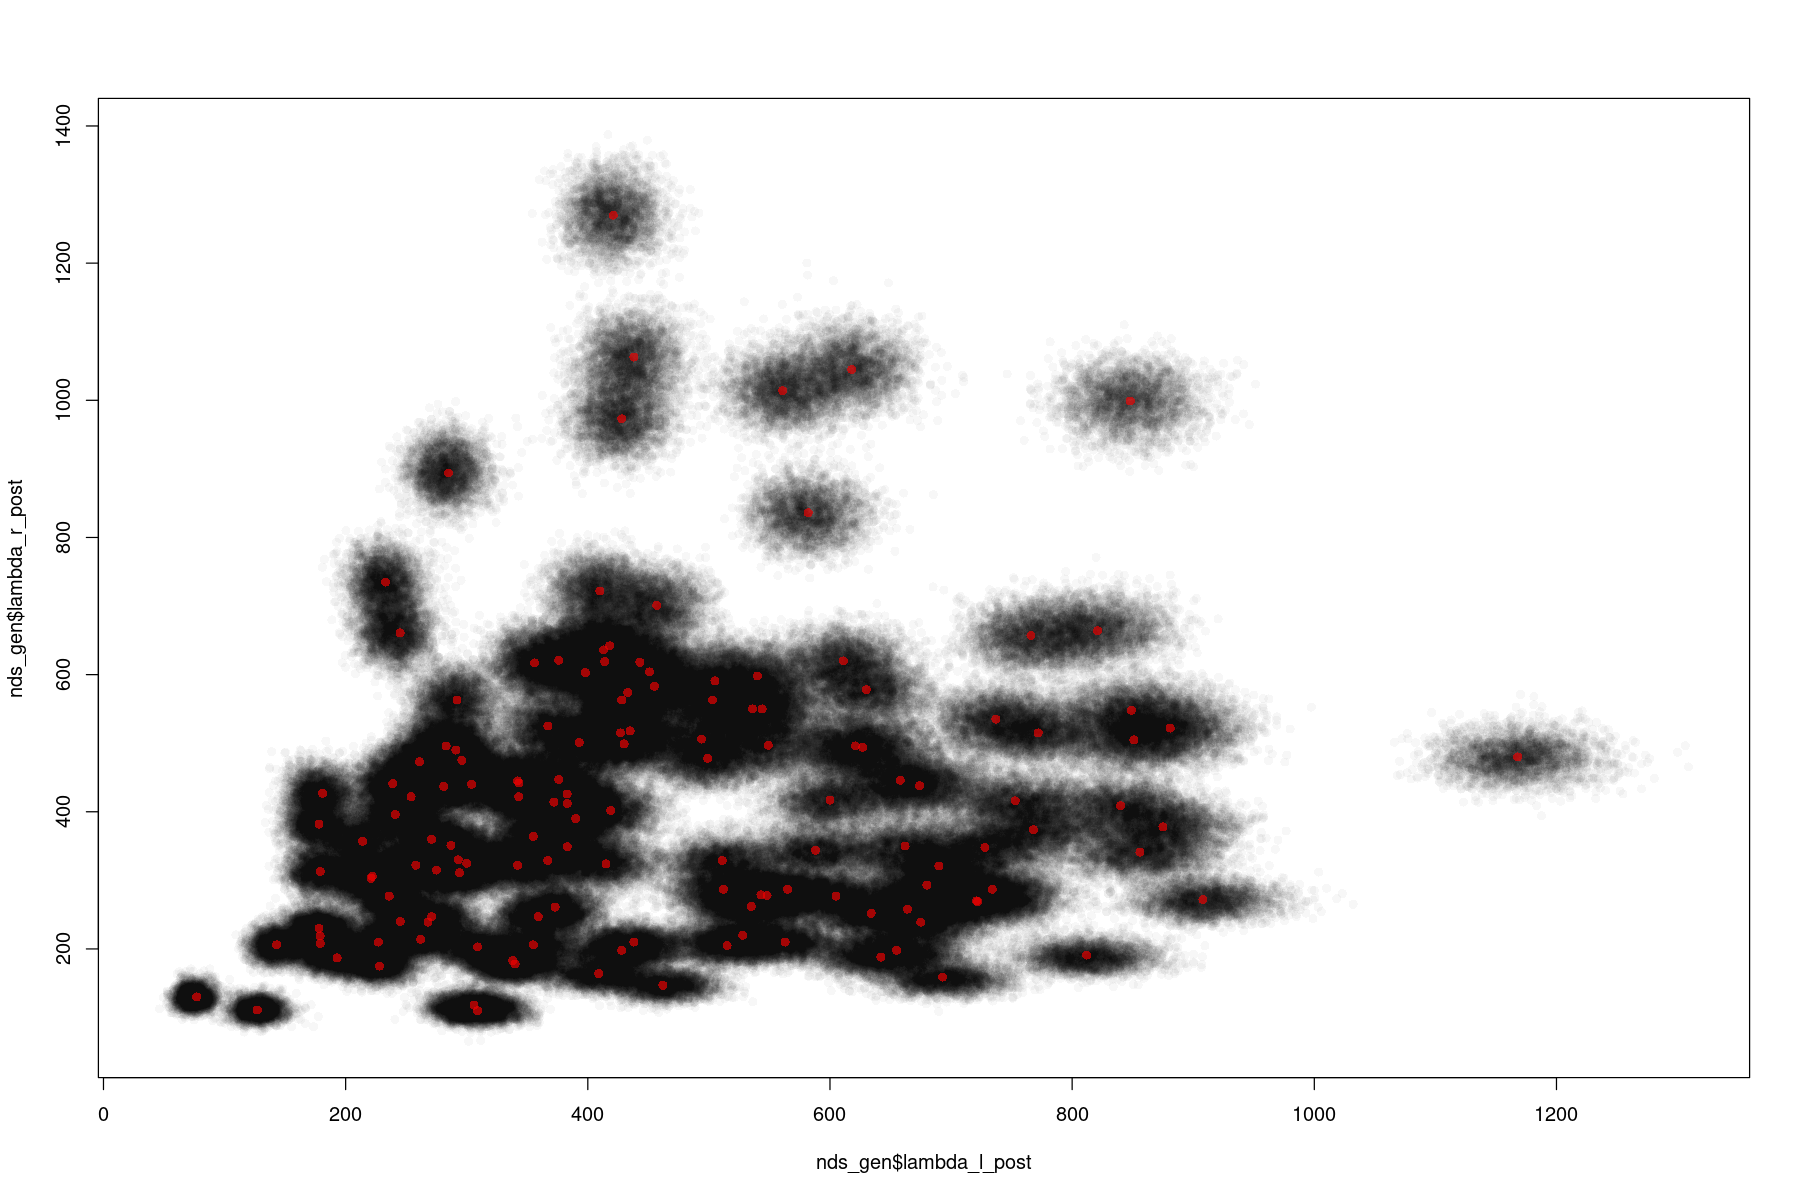

In [23]:
plot(nds_gen$lambda_l_post,nds_gen$lambda_r_post,pch=16,col='#00000008')
points(B_l,B_r,pch=16,col='#ee0000aa')

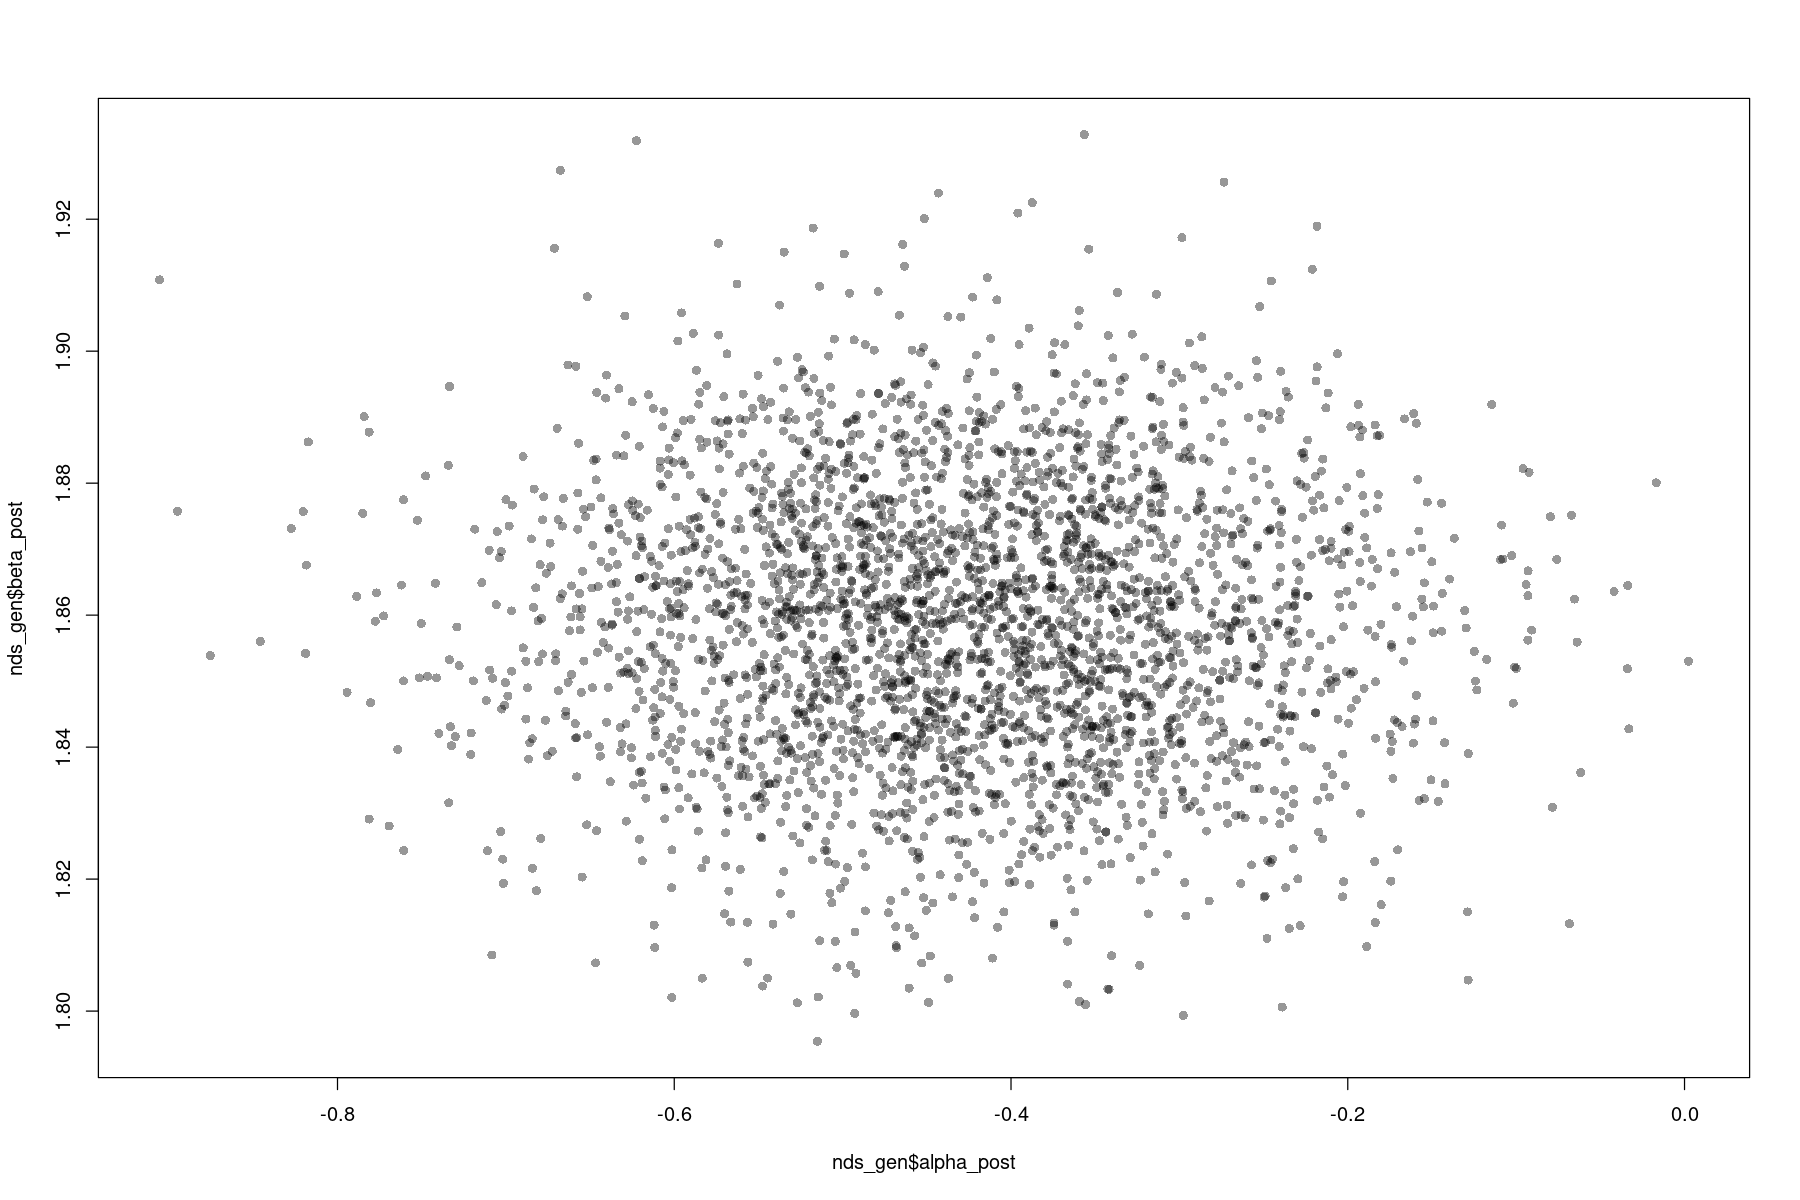

In [26]:
plot(nds_gen$alpha_post,nds_gen$beta_post,pch=16,col='#00000068')

In [14]:
bivariate_plot <- function(x,y,x_bins=20,y_bins=20){

#     x_bins <- 50
#     y_bins <- 50
    x_brks <- seq(min(x,na.rm=T)-.5,max(x,na.rm=T)+.5,length.out=x_bins)
    y_brks <- seq(min(y,na.rm=T)-.5,max(y,na.rm=T)+.5,length.out=y_bins)
    x_mids <- x_brks+(1/2)*(x_brks[2]-x_brks[1])
    y_mids <- y_brks+(1/2)*(y_brks[2]-y_brks[1])
    count_matrix <- array(dim=c(length(x_mids),length(y_mids)))
    for(i in 1:length(x_mids)){
        for(j in 1:length(y_mids)){
            count_matrix[i,j] <- sum(x>=x_brks[i]&x<x_brks[i+1]&y>=y_brks[j]&y<y_brks[j+1])
            }
    }


    x_range <- max(x_brks)-min(x_brks)
    y_range <- max(y_brks)-min(y_brks)
    plot(NULL,
         xlim=c(min(x_brks),max(x_brks)+x_range*.5),
         ylim=c(min(y_brks),max(y_brks)+y_range*.5))
    x_margin <- apply(count_matrix,FUN=sum,MAR=1)
    y_margin <- apply(count_matrix,FUN=sum,MAR=2)
    lines(x_mids,max(y_brks)+x_margin*15,col='blue',lwd=2)
    lines(y_margin+max(x_brks),y_mids,col='orange',lwd=2)
    for(i in 1:length(x_mids)){
        for(j in 1:length(y_mids)){
            points(x_mids[i],y_mids[j],cex=count_matrix[i,j]*1,pch=22)
        }
    }

}

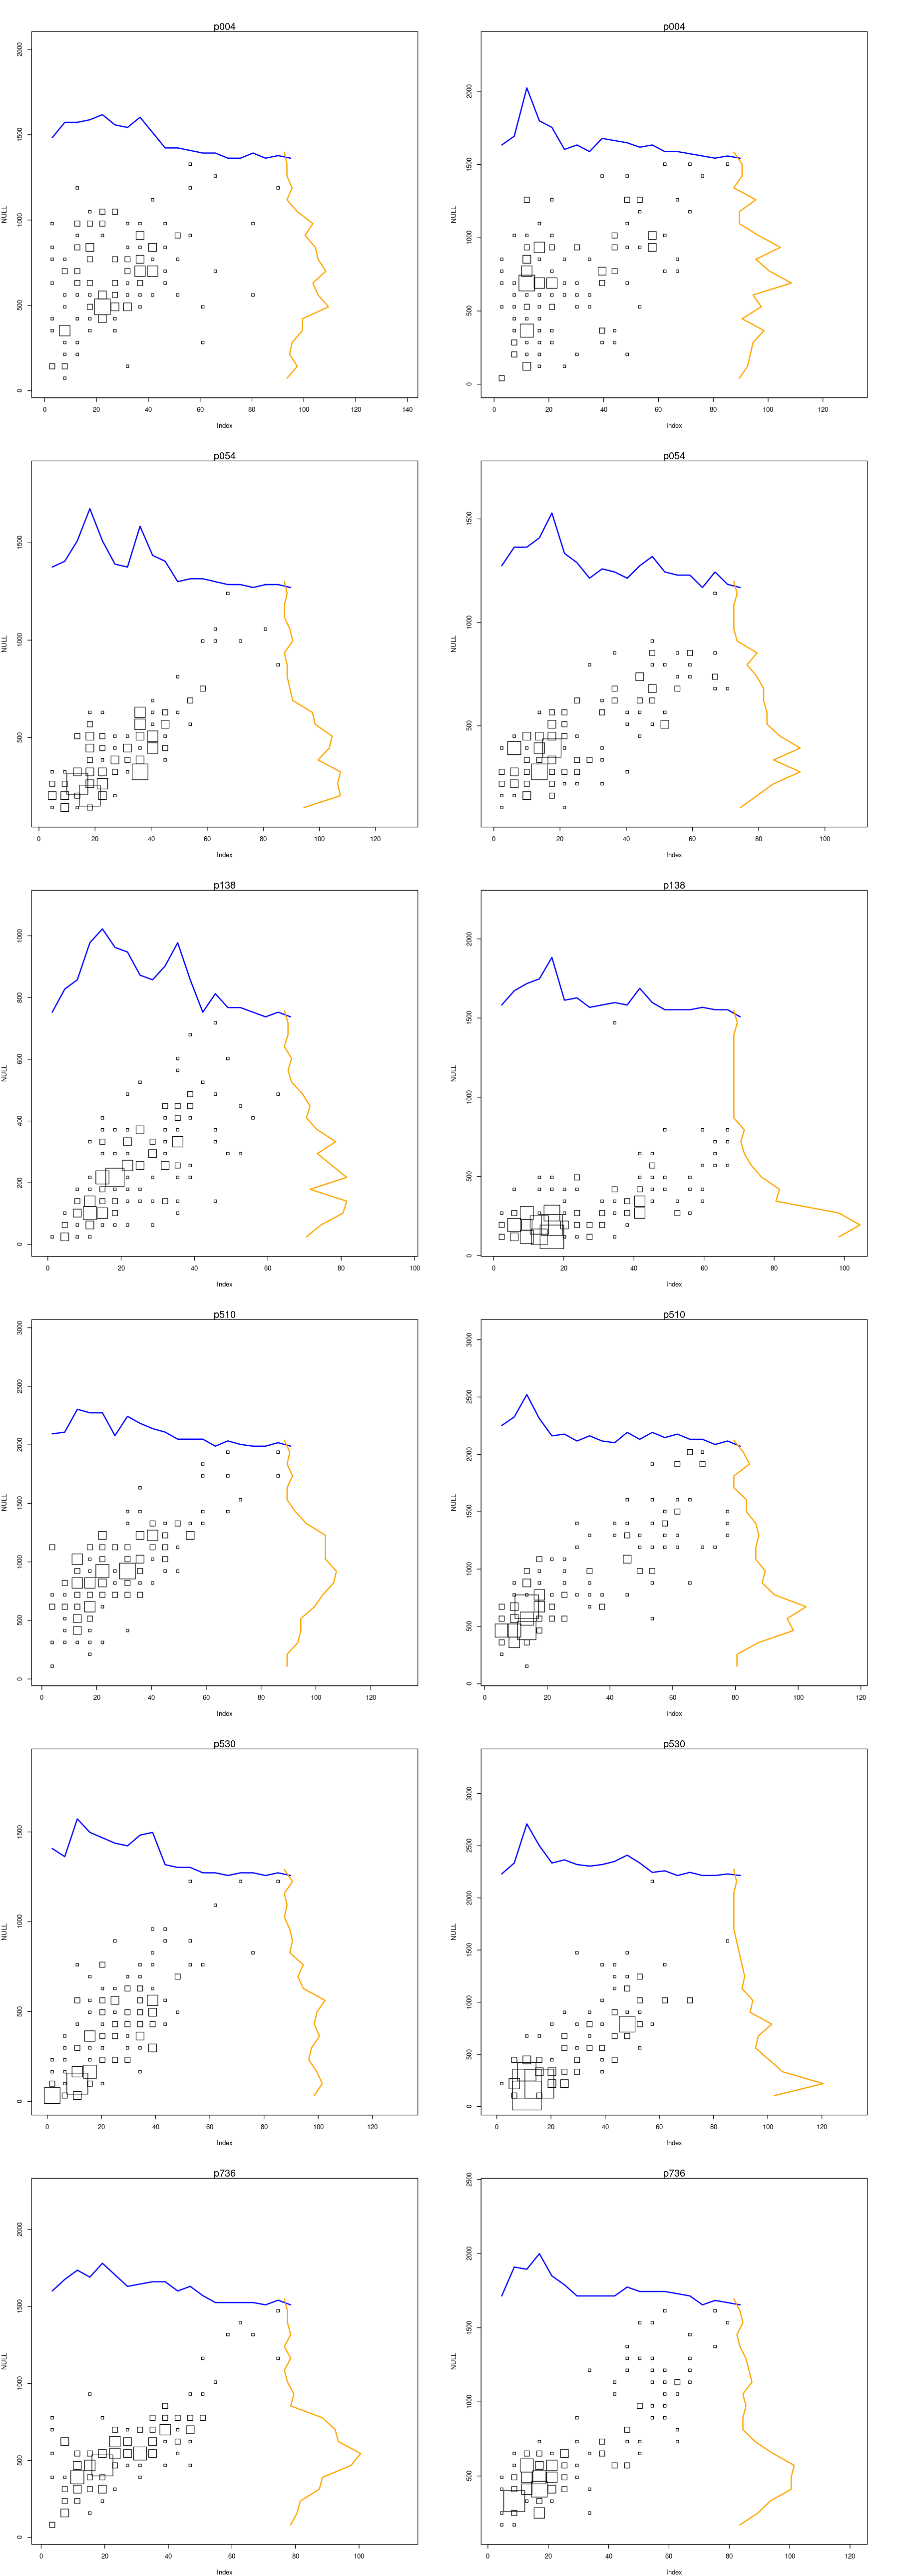

In [15]:
options(repr.plot.width=15,repr.plot.height=43)
layout(matrix(1:12,ncol=2,byrow=T))
par(mar=rep(4,4))
# bivariate_plot(stable$n_reinf_right,
#                stable$n_resp_right)

# bivariate_plot(stable$n_reinf_left,
#                stable$n_resp_left)

for(bb in unique(stable$bird)){
    bb_dta <- subset(stable,bird==bb)
    
    bivariate_plot(bb_dta$n_reinf_right,
                   bb_dta$n_resp_right)
    mtext(bb,3)
    bivariate_plot(bb_dta$n_reinf_left,
                   bb_dta$n_resp_left)
    mtext(bb,3)

}

In [16]:
pdf('bivariate_counts.pdf',width=6,height=18)
layout(matrix(1:12,ncol=2,byrow=T))
par(mar=rep(3,4))
# bivariate_plot(stable$n_reinf_right,
#                stable$n_resp_right)

# bivariate_plot(stable$n_reinf_left,
#                stable$n_resp_left)

for(bb in unique(stable$bird)){
    bb_dta <- subset(stable,bird==bb)
    
    bivariate_plot(bb_dta$n_reinf_right,
                   bb_dta$n_resp_right)
    mtext(bb,3)
    bivariate_plot(bb_dta$n_reinf_left,
                   bb_dta$n_resp_left)
    mtext(bb,3)

}
dev.off()

png 
  2

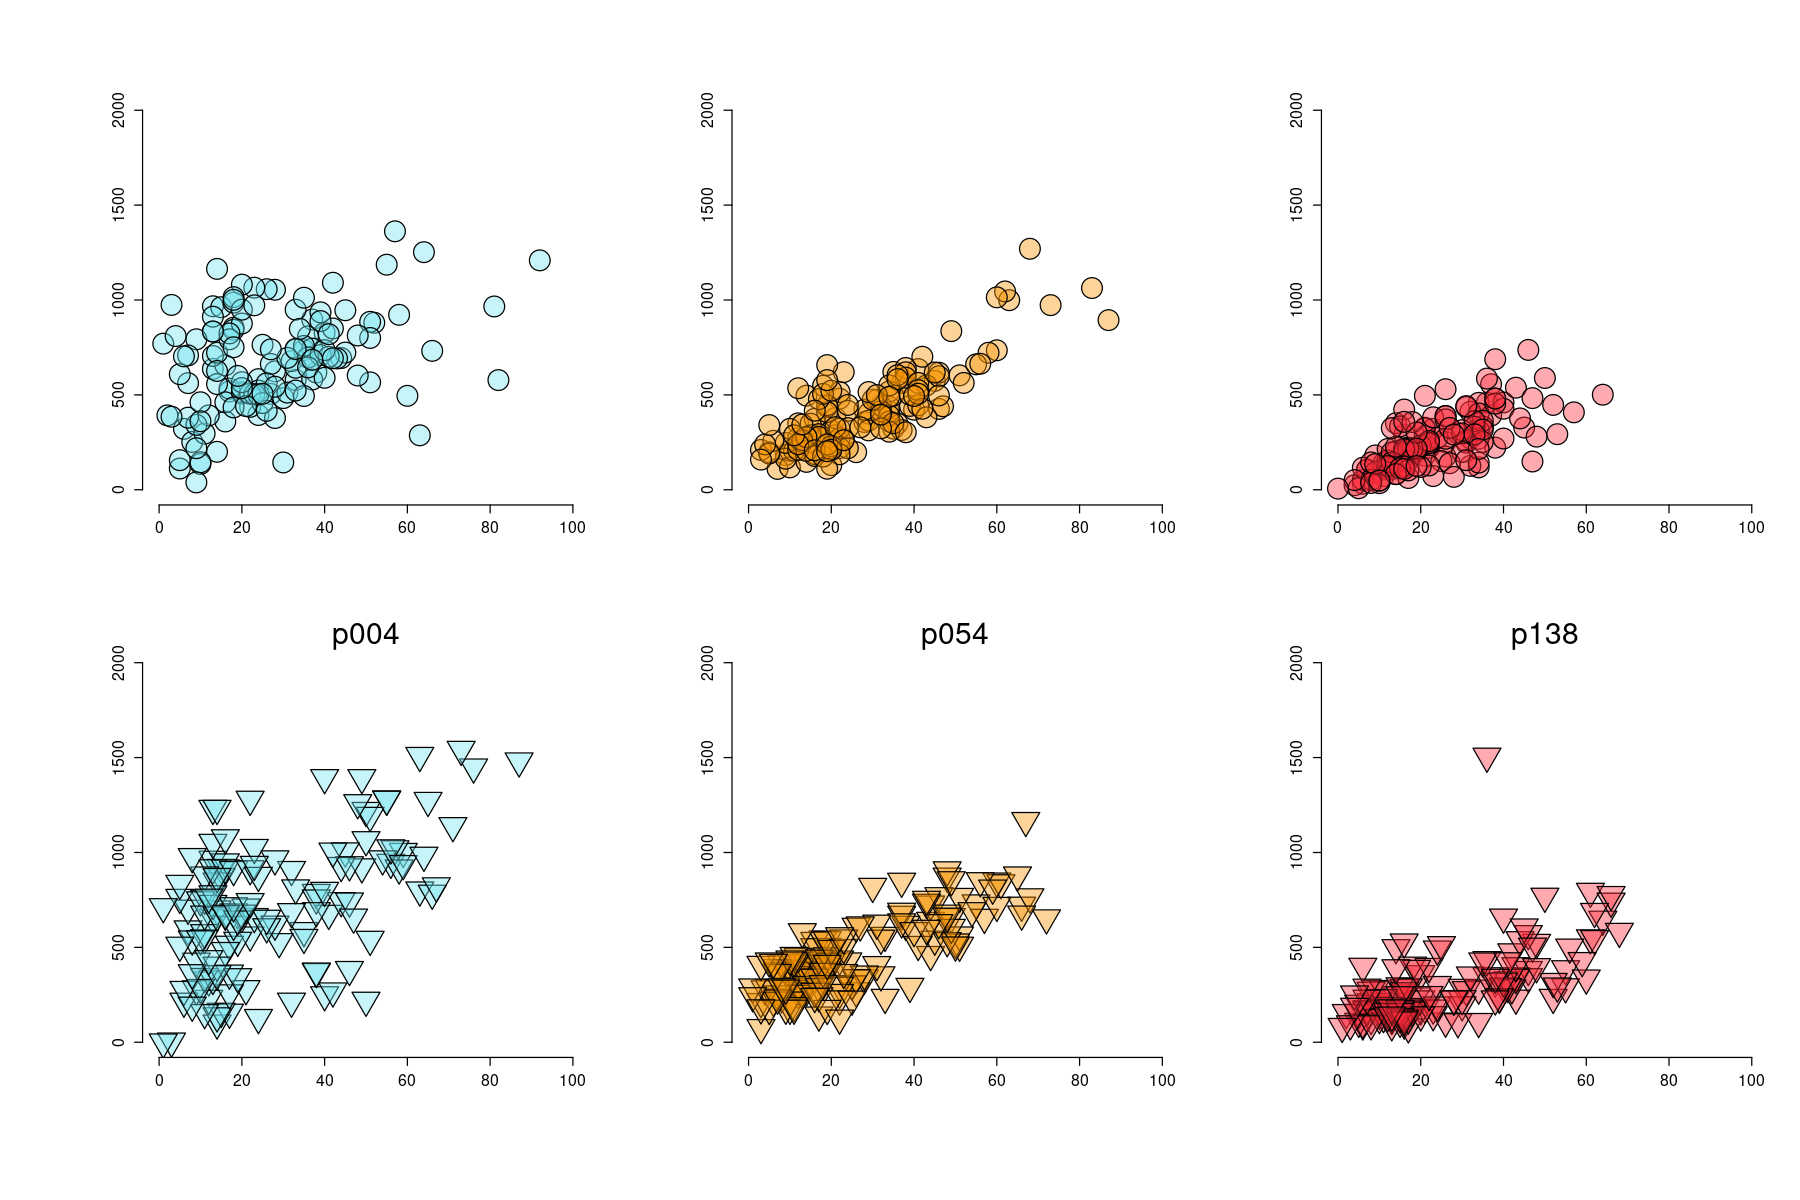

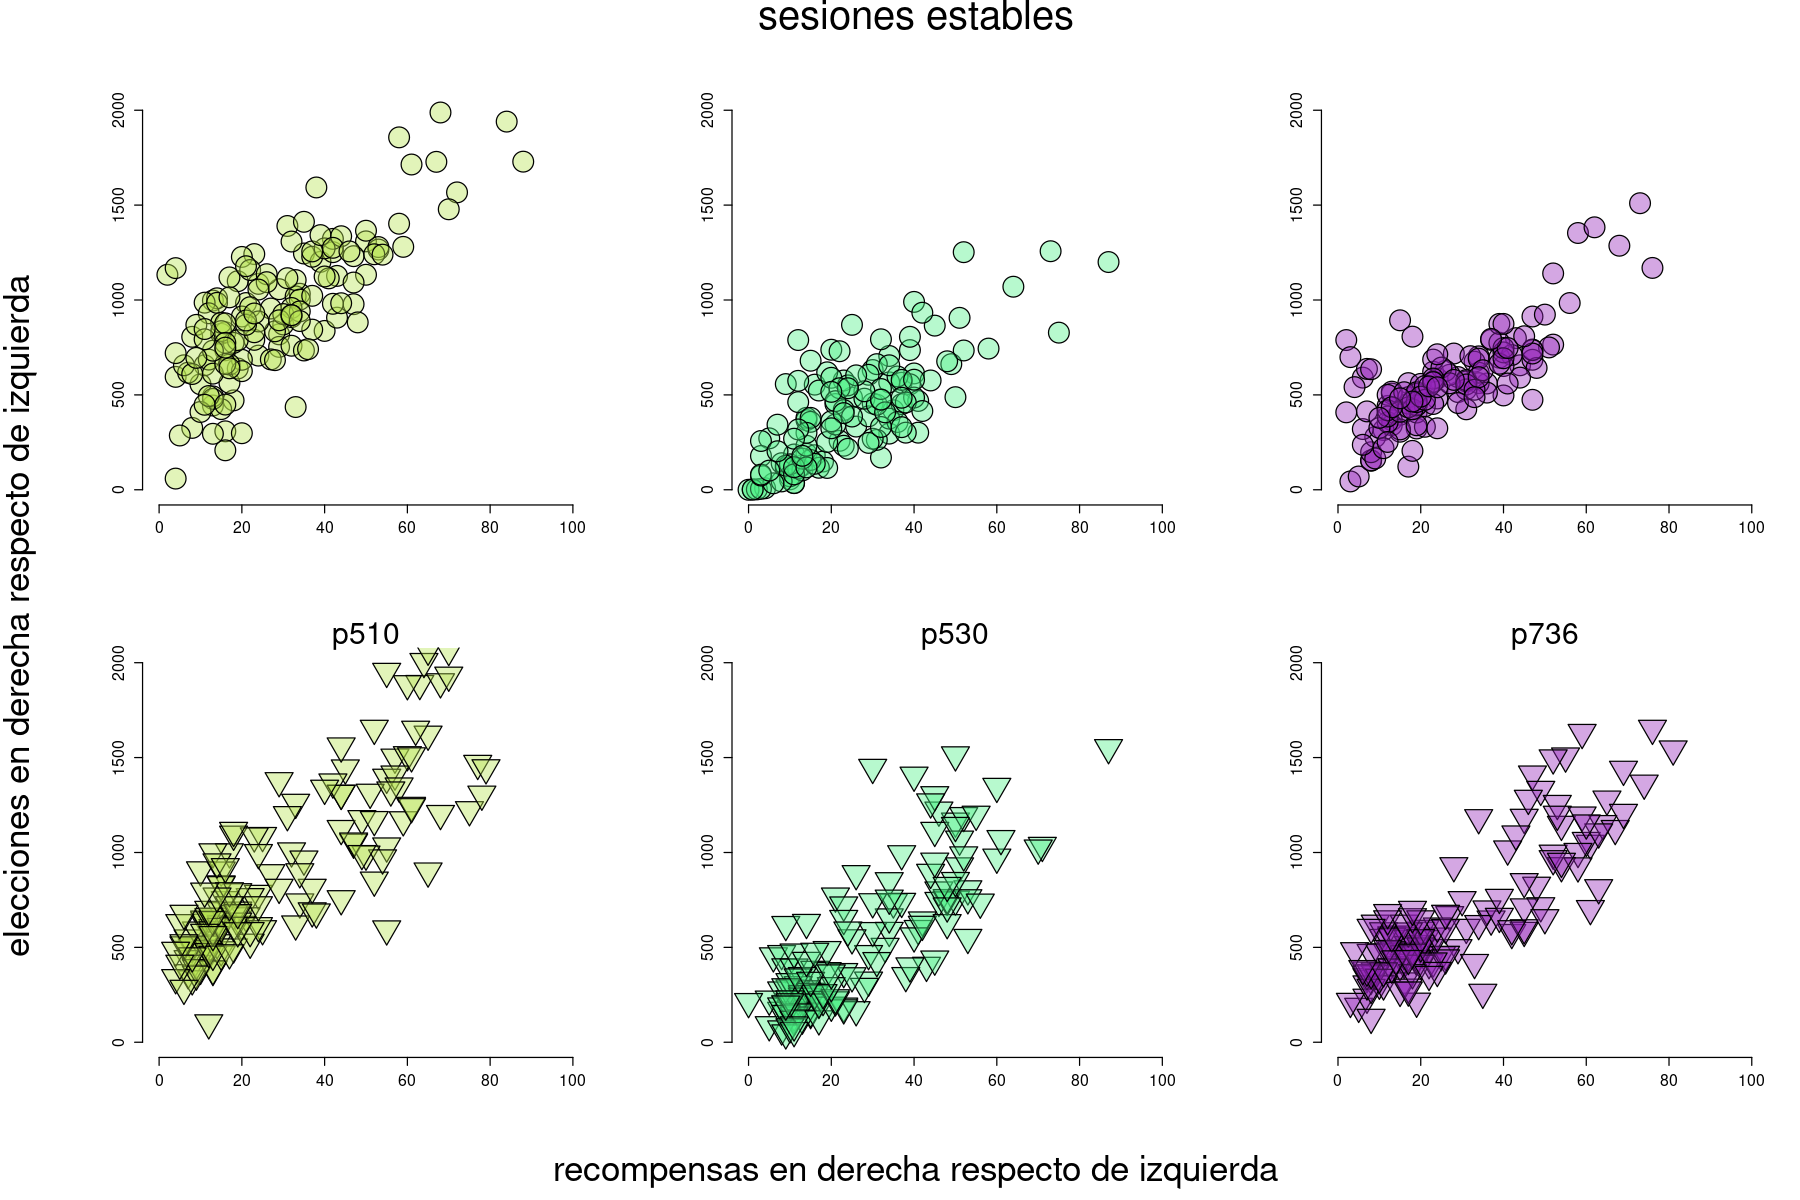

In [17]:
palette <- c("#72e5ef","#f79302","#fd2c3b",
             "#b8e450","#4cf185","#9525ba")
colors <- NULL
cntr <- 0
for(bb in unique(stable$bird)){
    cntr <- cntr+1
    colors[which(stable$bird==bb)] <- paste(palette[cntr],'66',sep='')
}
stable$colors <- colors

options(repr.plot.width=15,repr.plot.height=10)
layout(matrix(1:6,ncol=3))
par(mar=c(7,7,2,2),oma=c(2,2,4,0),cex.axis=1.2)
for(bb in unique(stable$bird)){
    bb_stable <- subset(stable,bird==bb)
    plot(NULL,xlim=c(0,100),ylim=c(0,2000),axes=F,ann=F)
    axis(1);axis(2)
    points(bb_stable$n_reinf_right,
           bb_stable$n_resp_right,
           pch=21,bg=bb_stable$colors,cex=3.5)
    
    plot(NULL,xlim=c(0,100),ylim=c(0,2000),axes=F,ann=F)
    axis(1);axis(2)
    points(bb_stable$n_reinf_left,
           bb_stable$n_resp_left,
           pch=25,bg=bb_stable$colors,cex=3.5)
    mtext(bb,3,cex=1.5)
}
mtext('recompensas en derecha respecto de izquierda',1,line=0,cex=1.75,outer=T)
mtext('elecciones en derecha respecto de izquierda',2,line=0,cex=1.75,outer=T)
mtext('sesiones estables',3,line=2,cex=2,outer=T)